In [11]:
# Test setup
print("🎉 FRESH POWER GENERATION PROJECT SETUP")
print("=" * 50)

import sys
print(f"Python executable: {sys.executable}")
print(f"Virtual environment: {'power_env' in sys.executable}")

# Test all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline

print("✅ All packages imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {LinearRegression().__class__.__module__}")

print("\n🚀 Ready to build Power Generation ML model!")

🎉 FRESH POWER GENERATION PROJECT SETUP
Python executable: d:\PowerGenProject\power_env\Scripts\python.exe
Virtual environment: True
✅ All packages imported successfully!
Pandas version: 2.3.1
NumPy version: 2.3.1
Scikit-learn version: sklearn.linear_model._base

🚀 Ready to build Power Generation ML model!


In [2]:
# Power Generation Data Creation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def create_power_generation_data(n_samples=2000):
    """Create realistic power generation dataset"""
    print("⚡ Generating power generation dataset...")
    
    np.random.seed(42)
    
    # Time series
    start_date = datetime(2023, 1, 1)
    timestamps = [start_date + timedelta(hours=i) for i in range(n_samples)]
    hours = np.arange(n_samples)
    
    # Weather patterns
    seasonal_temp = 20 + 15 * np.sin(2 * np.pi * hours / (24 * 365))
    daily_temp = 5 * np.sin(2 * np.pi * hours / 24)
    temp = seasonal_temp + daily_temp + np.random.normal(0, 3, n_samples)
    
    wind = np.maximum(0, 8 + np.random.normal(0, 4, n_samples))
    humidity = np.clip(60 - 0.3 * (temp - 20) + np.random.normal(0, 15, n_samples), 10, 95)
    barometer = np.random.normal(1013, 15, n_samples)
    weather = np.random.choice(['Clear', 'Sunny', 'Cloudy', 'Overcast', 'Rainy'], 
                              n_samples, p=[0.35, 0.25, 0.25, 0.1, 0.05])
    
    # Solar generation
    hour_of_day = np.array([t.hour for t in timestamps])
    day_of_year = np.array([t.timetuple().tm_yday for t in timestamps])
    
    solar_elevation = np.maximum(0, np.sin(np.pi * (hour_of_day - 6) / 12))
    seasonal_factor = 1 + 0.4 * np.sin(2 * np.pi * (day_of_year - 80) / 365)
    
    weather_factor = np.select([
        weather == 'Clear', weather == 'Sunny', weather == 'Cloudy',
        weather == 'Overcast', weather == 'Rainy'
    ], [1.0, 0.95, 0.4, 0.2, 0.05], default=0.5)
    
    temp_factor = 1 - 0.004 * np.maximum(0, temp - 25)
    solar_irradiance = 1000 * solar_elevation * seasonal_factor * weather_factor * temp_factor
    solar_irradiance = np.maximum(0, solar_irradiance + np.random.normal(0, 50, n_samples))
    
    solar_generation = 50 * (solar_irradiance / 1000) + np.random.normal(0, 2, n_samples)
    solar_generation = np.maximum(0, solar_generation)
    
    # Wind generation
    def wind_power_curve(wind_speed):
        cut_in, rated, cut_out = 3.0, 12.0, 25.0
        rated_power = 30.0
        return np.where(wind_speed < cut_in, 0,
               np.where(wind_speed < rated, 
                       rated_power * ((wind_speed - cut_in) / (rated - cut_in)) ** 3,
               np.where(wind_speed < cut_out, rated_power, 0)))
    
    wind_generation = wind_power_curve(wind) + np.random.normal(0, 1, n_samples)
    wind_generation = np.maximum(0, wind_generation)
    
    # Total generation
    renewable_total = solar_generation + wind_generation
    backup_needed = np.maximum(0, 70 - renewable_total)
    gas_generation = backup_needed * 0.85 + np.random.normal(0, 2, n_samples)
    gas_generation = np.maximum(0, gas_generation)
    
    total_generation = solar_generation + wind_generation + gas_generation
    gas_mxm = gas_generation * 0.2 + np.random.normal(0, 1, n_samples)
    
    return pd.DataFrame({
        'clock': timestamps,
        'temp': temp,
        'weather': weather,
        'wind': wind,
        'humidity': humidity,
        'barometer': barometer,
        'solar_irradiance': solar_irradiance,
        'solar_generation': solar_generation,
        'wind_generation': wind_generation,
        'gas_generation': gas_generation,
        'total_generation': total_generation,
        'GAS_mxm': gas_mxm
    })

# Generate data
data = create_power_generation_data(2000)
print(f"✅ Dataset created: {data.shape}")
print(f"⚡ Generation range: {data['total_generation'].min():.1f} - {data['total_generation'].max():.1f} kW")
data.head()

⚡ Generating power generation dataset...
✅ Dataset created: (2000, 12)
⚡ Generation range: 53.9 - 81.1 kW


,clock,temp,weather,wind,humidity,barometer,solar_irradiance,solar_generation,wind_generation,gas_generation,total_generation,GAS_mxm
0,2023-01-01 00:00:00,21.490142,Clear,5.299287,46.600553,996.288780,23.500683,3.313929,0.000000,60.532837,63.846766,11.707539
1,2023-01-01 01:00:00,20.890061,Sunny,7.421925,59.264929,1003.536037,5.169100,0.250170,2.899120,57.395135,60.544425,11.879459
2,2023-01-01 02:00:00,24.464583,Overcast,4.830320,58.930878,998.869097,0.000000,0.369537,0.851912,56.763721,57.985171,12.784633
3,2023-01-01 03:00:00,28.136900,Sunny,6.768154,64.648385,1004.780063,25.841263,0.796231,1.341302,60.613856,62.751389,11.663767
4,2023-01-01 04:00:00,23.670702,Cloudy,0.425541,38.395914,1009.787745,107.817482,6.530627,0.000000,50.357741,56.888368,8.689999


🔍 POWER GENERATION DATA EXPLORATION
📈 Key Statistics:
          temp     wind  solar_irradiance  total_generation  solar_generation  \
count  2000.00  2000.00           2000.00           2000.00           2000.00   
mean     29.18     8.01            176.31             62.53              9.17   
std       6.48     3.95            240.46              3.24             11.94   
min      10.58     0.00              0.00             53.89              0.00   
25%      24.90     5.16              0.00             60.26              0.48   
50%      29.31     8.00             51.28             62.24              3.32   
75%      33.83    10.66            273.12             64.47             14.00   
max      48.15    23.70           1065.87             81.14             52.42   

       wind_generation  
count          2000.00  
mean             10.31  
std              11.10  
min               0.00  
25%               0.87  
50%               5.33  
75%              18.19  
max             

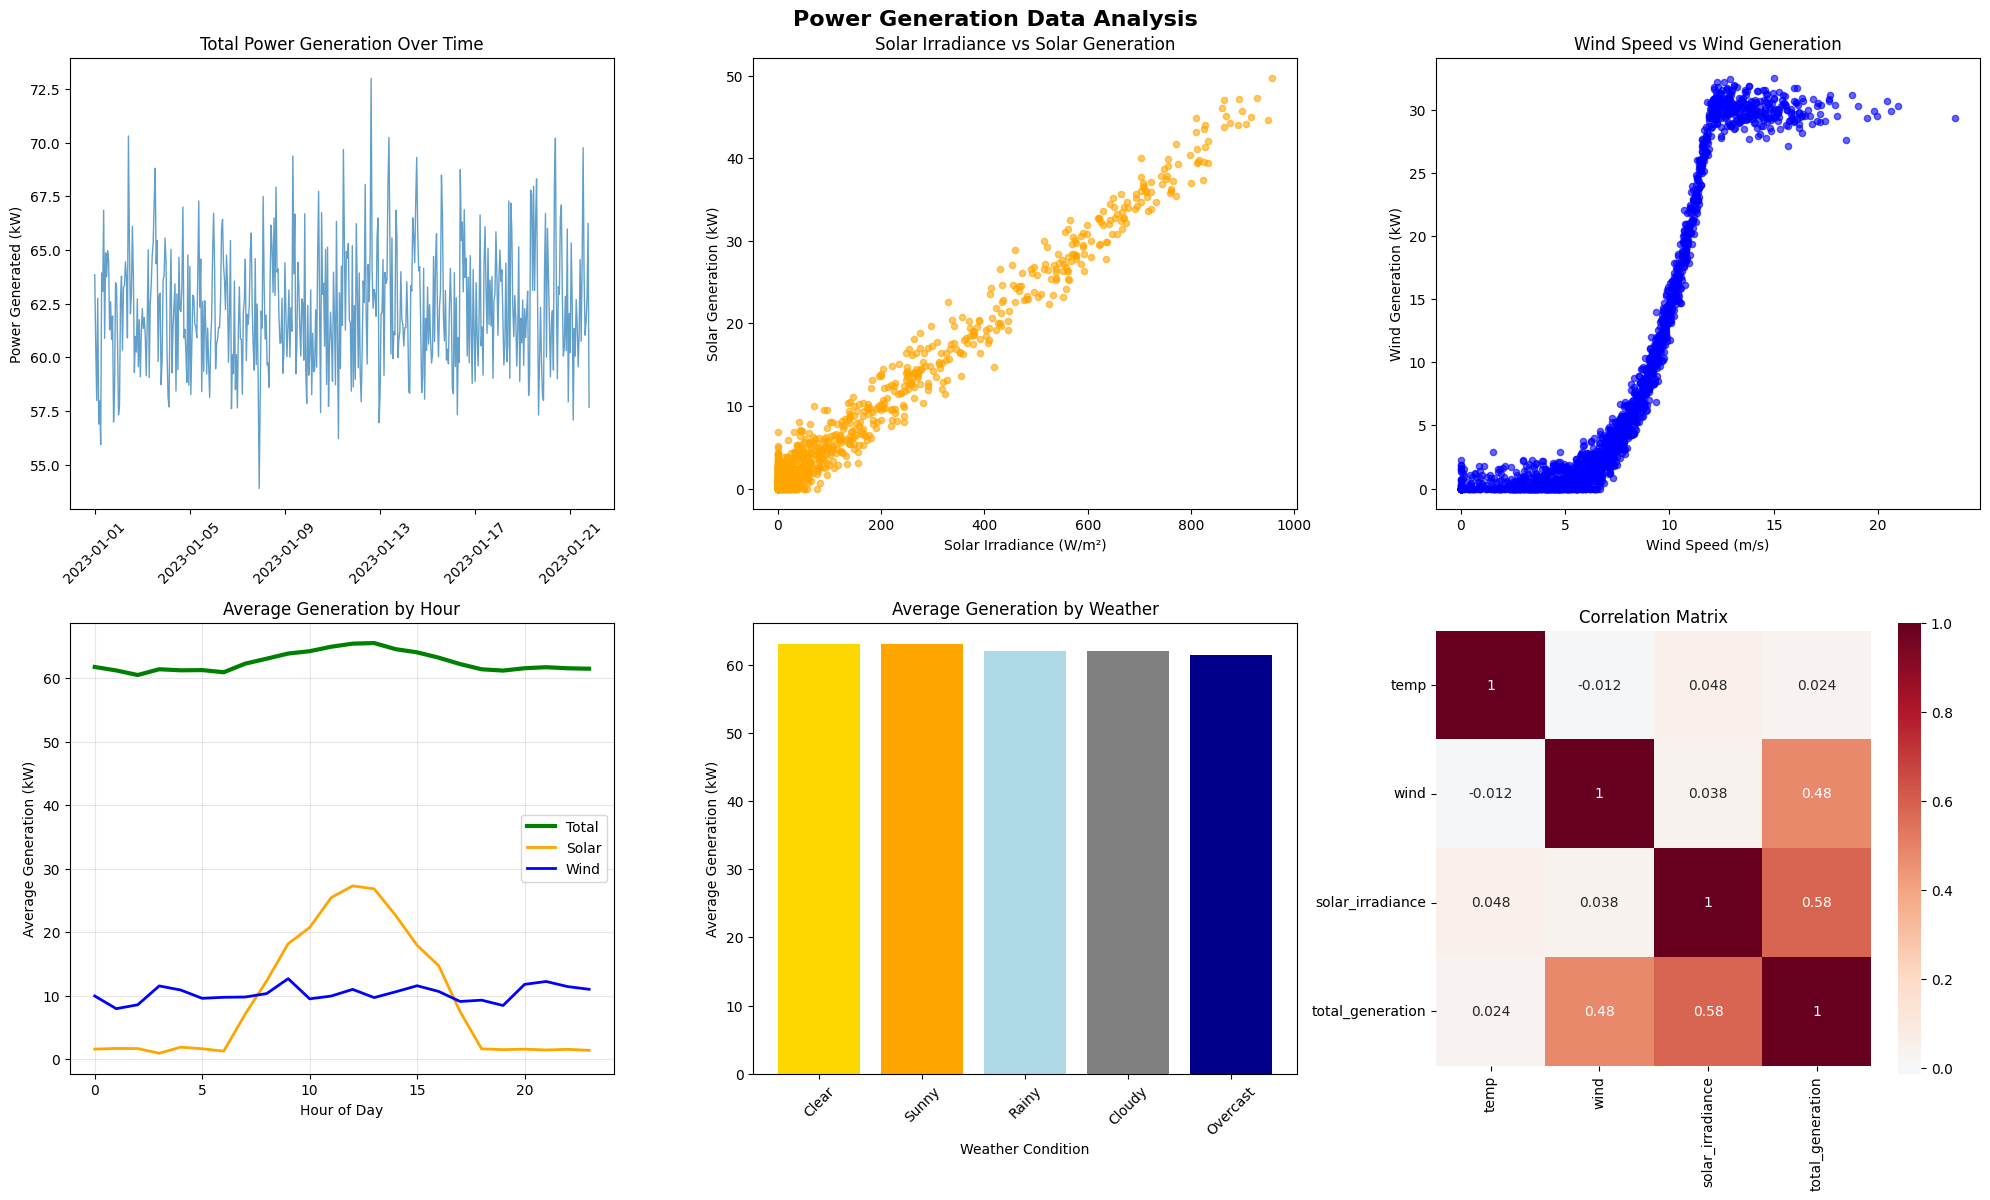


🔍 KEY INSIGHTS:
   ☀️ Peak solar hour: 12:00
   🌦️ Best weather: Clear (63.1 kW)
   📊 Solar-irradiance correlation: 0.581
   💨 Wind-generation correlation: 0.479


In [3]:
print("🔍 POWER GENERATION DATA EXPLORATION")
print("=" * 50)

# Basic statistics
print("📈 Key Statistics:")
key_cols = ['temp', 'wind', 'solar_irradiance', 'total_generation', 'solar_generation', 'wind_generation']
print(data[key_cols].describe().round(2))

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Power Generation Data Analysis', fontsize=16, fontweight='bold')

# 1. Total generation over time
axes[0, 0].plot(data['clock'][:500], data['total_generation'][:500], alpha=0.7, linewidth=1)
axes[0, 0].set_title('Total Power Generation Over Time')
axes[0, 0].set_ylabel('Power Generated (kW)')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Solar irradiance vs solar generation
sample_data = data.sample(1000)
axes[0, 1].scatter(sample_data['solar_irradiance'], sample_data['solar_generation'],
                  alpha=0.6, color='orange', s=20)
axes[0, 1].set_title('Solar Irradiance vs Solar Generation')
axes[0, 1].set_xlabel('Solar Irradiance (W/m²)')
axes[0, 1].set_ylabel('Solar Generation (kW)')

# 3. Wind speed vs wind generation
axes[0, 2].scatter(data['wind'], data['wind_generation'], alpha=0.6, color='blue', s=20)
axes[0, 2].set_title('Wind Speed vs Wind Generation')
axes[0, 2].set_xlabel('Wind Speed (m/s)')
axes[0, 2].set_ylabel('Wind Generation (kW)')

# 4. Hourly generation patterns
hourly_total = data.groupby(data['clock'].dt.hour)['total_generation'].mean()
hourly_solar = data.groupby(data['clock'].dt.hour)['solar_generation'].mean()
hourly_wind = data.groupby(data['clock'].dt.hour)['wind_generation'].mean()

axes[1, 0].plot(hourly_total.index, hourly_total.values, 'g-', linewidth=3, label='Total')
axes[1, 0].plot(hourly_solar.index, hourly_solar.values, color='orange', linewidth=2, label='Solar')
axes[1, 0].plot(hourly_wind.index, hourly_wind.values, color='blue', linewidth=2, label='Wind')
axes[1, 0].set_title('Average Generation by Hour')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Generation (kW)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Weather impact
weather_gen = data.groupby('weather')['total_generation'].mean().sort_values(ascending=False)
colors = ['gold', 'orange', 'lightblue', 'gray', 'darkblue']
axes[1, 1].bar(weather_gen.index, weather_gen.values, color=colors)
axes[1, 1].set_title('Average Generation by Weather')
axes[1, 1].set_xlabel('Weather Condition')
axes[1, 1].set_ylabel('Average Generation (kW)')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Correlation matrix
corr_cols = ['temp', 'wind', 'solar_irradiance', 'total_generation']
corr_matrix = data[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
           square=True, ax=axes[1, 2])
axes[1, 2].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Key insights
print(f"\n🔍 KEY INSIGHTS:")
print(f"   ☀️ Peak solar hour: {hourly_solar.idxmax()}:00")
print(f"   🌦️ Best weather: {weather_gen.index[0]} ({weather_gen.iloc[0]:.1f} kW)")
print(f"   📊 Solar-irradiance correlation: {corr_matrix.loc['solar_irradiance', 'total_generation']:.3f}")
print(f"   💨 Wind-generation correlation: {corr_matrix.loc['wind', 'total_generation']:.3f}")

In [7]:
print("⚙️ FEATURE ENGINEERING FOR GENERATION PREDICTION")
print("=" * 50)

# Create enhanced features
processed_data = data.copy()

# Time-based features
processed_data['hour'] = processed_data['clock'].dt.hour
processed_data['day_of_week'] = processed_data['clock'].dt.dayofweek
processed_data['month'] = processed_data['clock'].dt.month
processed_data['day_of_year'] = processed_data['clock'].dt.dayofyear
processed_data['is_weekend'] = (processed_data['day_of_week'] >= 5).astype(int)

# Solar-specific features
processed_data['is_daylight'] = ((processed_data['hour'] >= 6) &
                               (processed_data['hour'] <= 18)).astype(int)
processed_data['solar_hour_factor'] = np.maximum(0,
    np.sin(np.pi * (processed_data['hour'] - 6) / 12))

# Wind-specific features (cubic relationship)
processed_data['wind_squared'] = processed_data['wind'] ** 2
processed_data['wind_cubed'] = processed_data['wind'] ** 3

# Weather interaction features
processed_data['temp_solar_interaction'] = (processed_data['temp'] *
                                          processed_data['solar_irradiance'] / 1000)
processed_data['humidity_temp'] = processed_data['humidity'] * processed_data['temp'] / 100

# Seasonal features
processed_data['season'] = ((processed_data['month'] - 1) // 3) + 1
processed_data['summer_factor'] = ((processed_data['month'] >= 6) &
                                 (processed_data['month'] <= 8)).astype(int)

# Encode categorical weather
le_weather = LabelEncoder()
processed_data['weather_encoded'] = le_weather.fit_transform(processed_data['weather'])

# Define features for modeling (exclude target and intermediate variables)
exclude_cols = ['clock', 'total_generation', 'solar_generation', 'wind_generation',
               'gas_generation', 'weather', 'season']
feature_columns = [col for col in processed_data.columns if col not in exclude_cols]

print(f"📊 Original features: {len(data.columns)}")
print(f"📊 Engineered features: {len(processed_data.columns)}")
print(f"✅ Model features: {len(feature_columns)}")
print(f"🎯 Target: total_generation")

print(f"\n📋 Features for modeling:")
for i, feature in enumerate(feature_columns, 1):
    print(f"   {i:2d}. {feature}")

⚙️ FEATURE ENGINEERING FOR GENERATION PREDICTION
📊 Original features: 12
📊 Engineered features: 26
✅ Model features: 19
🎯 Target: total_generation

📋 Features for modeling:
    1. temp
    2. wind
    3. humidity
    4. barometer
    5. solar_irradiance
    6. GAS_mxm
    7. hour
    8. day_of_week
    9. month
   10. day_of_year
   11. is_weekend
   12. is_daylight
   13. solar_hour_factor
   14. wind_squared
   15. wind_cubed
   16. temp_solar_interaction
   17. humidity_temp
   18. summer_factor
   19. weather_encoded


In [8]:
print("🎯 DATA PREPARATION FOR MACHINE LEARNING")
print("=" * 50)

# Separate features and target
X = processed_data[feature_columns]
y = processed_data['total_generation']  # TARGET: Power generated

print(f"📊 Feature matrix shape: {X.shape}")
print(f"📊 Target vector shape: {y.shape}")

# Time-based split (important for time series data)
test_size = 0.2
split_idx = int(len(X) * (1 - test_size))

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"\n✂️ Time-based split:")
print(f"   Training samples: {len(X_train):,}")
print(f"   Testing samples:  {len(X_test):,}")
print(f"   Split preserves chronological order")

# Feature scaling (important for linear regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n📏 Feature scaling completed")
print(f"   Mean of scaled features: {X_train_scaled.mean():.3f}")
print(f"   Std of scaled features: {X_train_scaled.std():.3f}")

🎯 DATA PREPARATION FOR MACHINE LEARNING
📊 Feature matrix shape: (2000, 19)
📊 Target vector shape: (2000,)

✂️ Time-based split:
   Training samples: 1,600
   Testing samples:  400
   Split preserves chronological order

📏 Feature scaling completed
   Mean of scaled features: -0.000
   Std of scaled features: 0.973


In [9]:
print("🤖 TRAINING LINEAR REGRESSION MODEL")
print("=" * 50)

# Initialize and train linear regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("✅ Model training completed!")

# Display model coefficients
print(f"\n📊 Model Parameters:")
print(f"   Intercept: {model.intercept_:.3f} kW")
print(f"   Number of coefficients: {len(model.coef_)}")

# Show most important coefficients
coef_data = list(zip(feature_columns, model.coef_))
coef_data.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\n🏆 Top 10 Most Important Features:")
for i, (feature, coef) in enumerate(coef_data[:10], 1):
    direction = "↑" if coef > 0 else "↓"
    print(f"   {i:2d}. {feature:20}: {coef:8.3f} {direction}")

# Model interpretation
print(f"\n💡 Model Interpretation:")
print(f"   • Positive coefficients: Increase generation")
print(f"   • Negative coefficients: Decrease generation")
print(f"   • Larger absolute values: More impact")

🤖 TRAINING LINEAR REGRESSION MODEL
✅ Model training completed!

📊 Model Parameters:
   Intercept: 62.453 kW
   Number of coefficients: 19

🏆 Top 10 Most Important Features:
    1. wind_squared        :   11.750 ↑
    2. wind_cubed          :   -6.106 ↓
    3. wind                :   -3.790 ↓
    4. solar_irradiance    :    2.141 ↑
    5. GAS_mxm             :    1.217 ↑
    6. temp_solar_interaction:    0.280 ↑
    7. day_of_year         :    0.216 ↑
    8. month               :   -0.172 ↓
    9. day_of_week         :   -0.089 ↓
   10. temp                :   -0.074 ↓

💡 Model Interpretation:
   • Positive coefficients: Increase generation
   • Negative coefficients: Decrease generation
   • Larger absolute values: More impact


📊 MODEL EVALUATION
🎯 Model Performance Metrics:
   MAE (Mean Absolute Error):     1.83 kW
   RMSE (Root Mean Square Error): 2.29 kW
   R² (R-squared):                0.653
   MAPE (Mean Absolute % Error):  2.90%

💡 Performance Interpretation:
   Average generation: 62.8 kW
   Typical error: ±1.8 kW (2.9%)
   Model explains 65.3% of generation variance


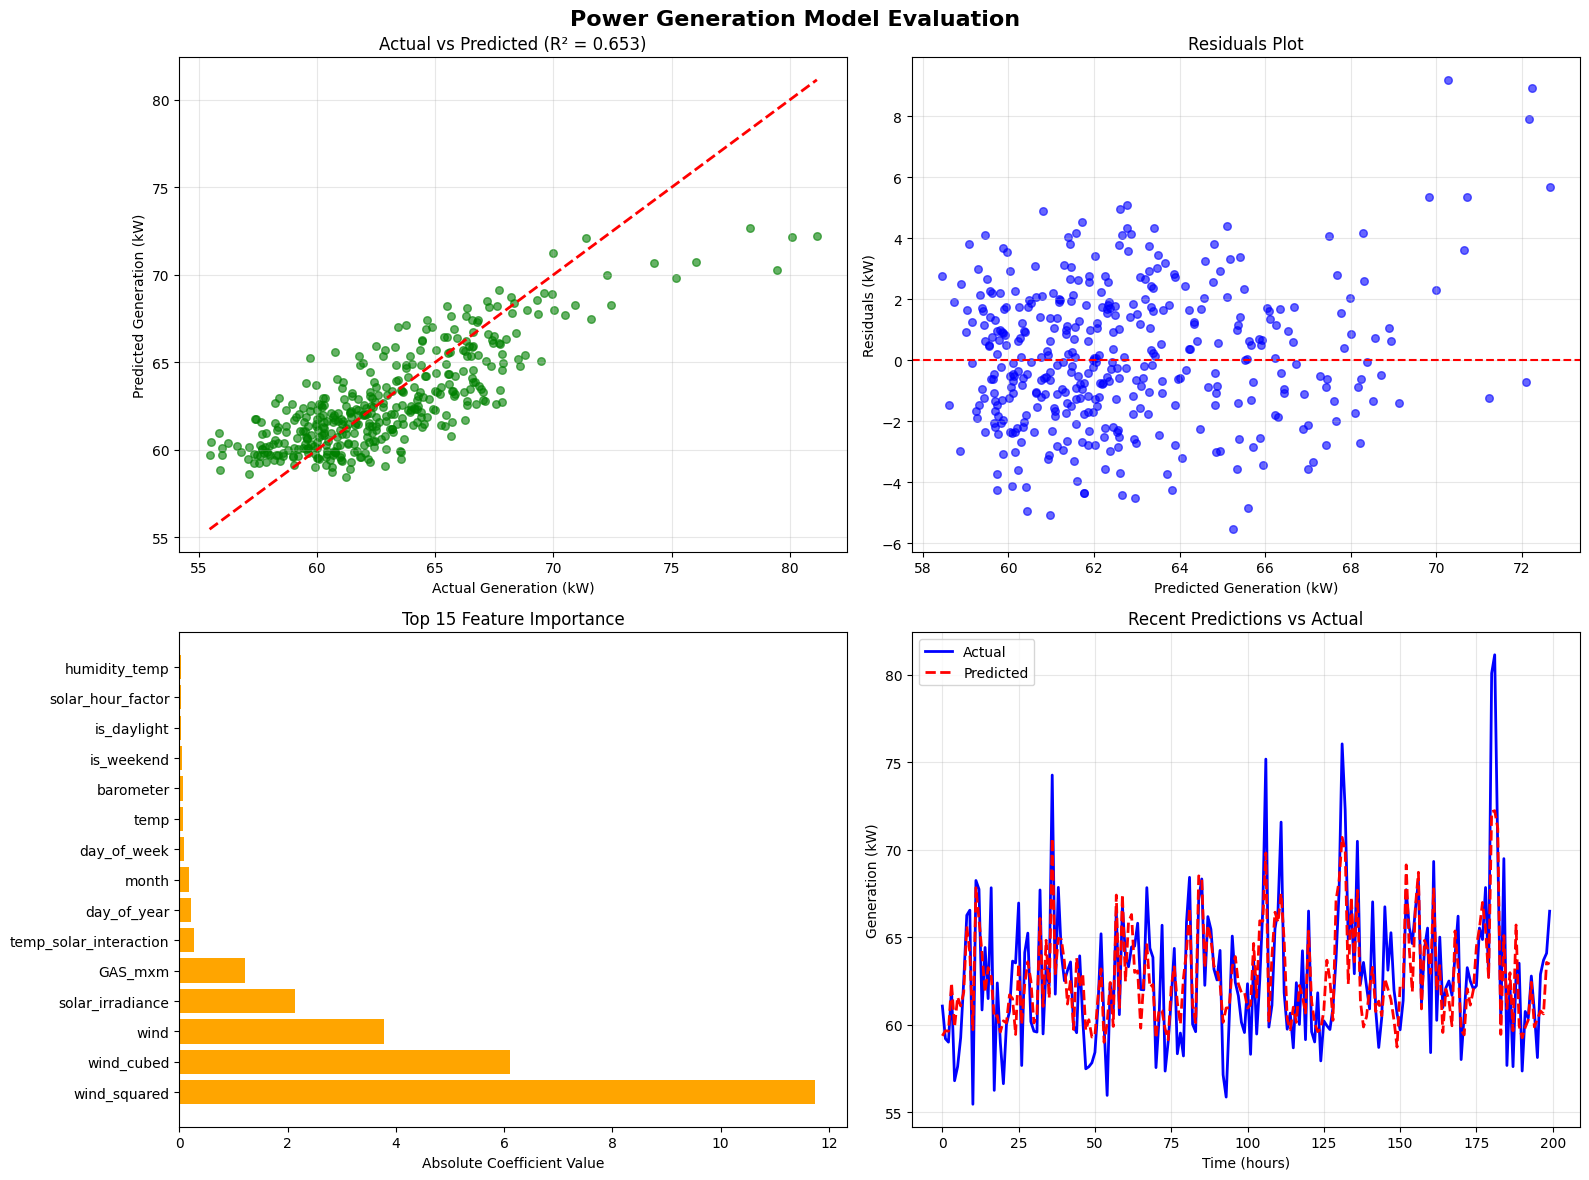

⚠️ Model could be improved


In [12]:
print("📊 MODEL EVALUATION")
print("=" * 50)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Display results
print(f"🎯 Model Performance Metrics:")
print(f"   MAE (Mean Absolute Error):     {mae:.2f} kW")
print(f"   RMSE (Root Mean Square Error): {rmse:.2f} kW")
print(f"   R² (R-squared):                {r2:.3f}")
print(f"   MAPE (Mean Absolute % Error):  {mape:.2f}%")

# Performance interpretation
avg_generation = y_test.mean()
print(f"\n💡 Performance Interpretation:")
print(f"   Average generation: {avg_generation:.1f} kW")
print(f"   Typical error: ±{mae:.1f} kW ({mae/avg_generation*100:.1f}%)")
print(f"   Model explains {r2*100:.1f}% of generation variance")

# Create evaluation visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Power Generation Model Evaluation', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred, alpha=0.6, s=30, color='green')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Generation (kW)')
axes[0, 0].set_ylabel('Predicted Generation (kW)')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {r2:.3f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals, alpha=0.6, s=30, color='blue')
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Generation (kW)')
axes[0, 1].set_ylabel('Residuals (kW)')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature importance
top_features = sorted(zip(feature_columns, np.abs(model.coef_)),
                     key=lambda x: x[1], reverse=True)[:15]
features, importance = zip(*top_features)

y_pos = np.arange(len(features))
axes[1, 0].barh(y_pos, importance, color='orange')
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(features)
axes[1, 0].set_xlabel('Absolute Coefficient Value')
axes[1, 0].set_title('Top 15 Feature Importance')

# 4. Prediction vs actual time series
n_show = min(200, len(y_test))
time_index = range(n_show)
axes[1, 1].plot(time_index, y_test.iloc[-n_show:].values, 'b-',
               label='Actual', linewidth=2)
axes[1, 1].plot(time_index, y_pred[-n_show:], 'r--',
               label='Predicted', linewidth=2)
axes[1, 1].set_xlabel('Time (hours)')
axes[1, 1].set_ylabel('Generation (kW)')
axes[1, 1].set_title('Recent Predictions vs Actual')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance assessment
if r2 > 0.8:
    print("🏆 Excellent model performance!")
elif r2 > 0.7:
    print("✅ Good model performance!")
else:
    print("⚠️ Model could be improved")

🔮 FUTURE POWER GENERATION FORECASTING
⚡ Generating 48-hour generation forecast...
✅ Generated 48 predictions
⚡ Average predicted generation: 63.47 kW
📊 Forecast range: 63.34 - 63.62 kW


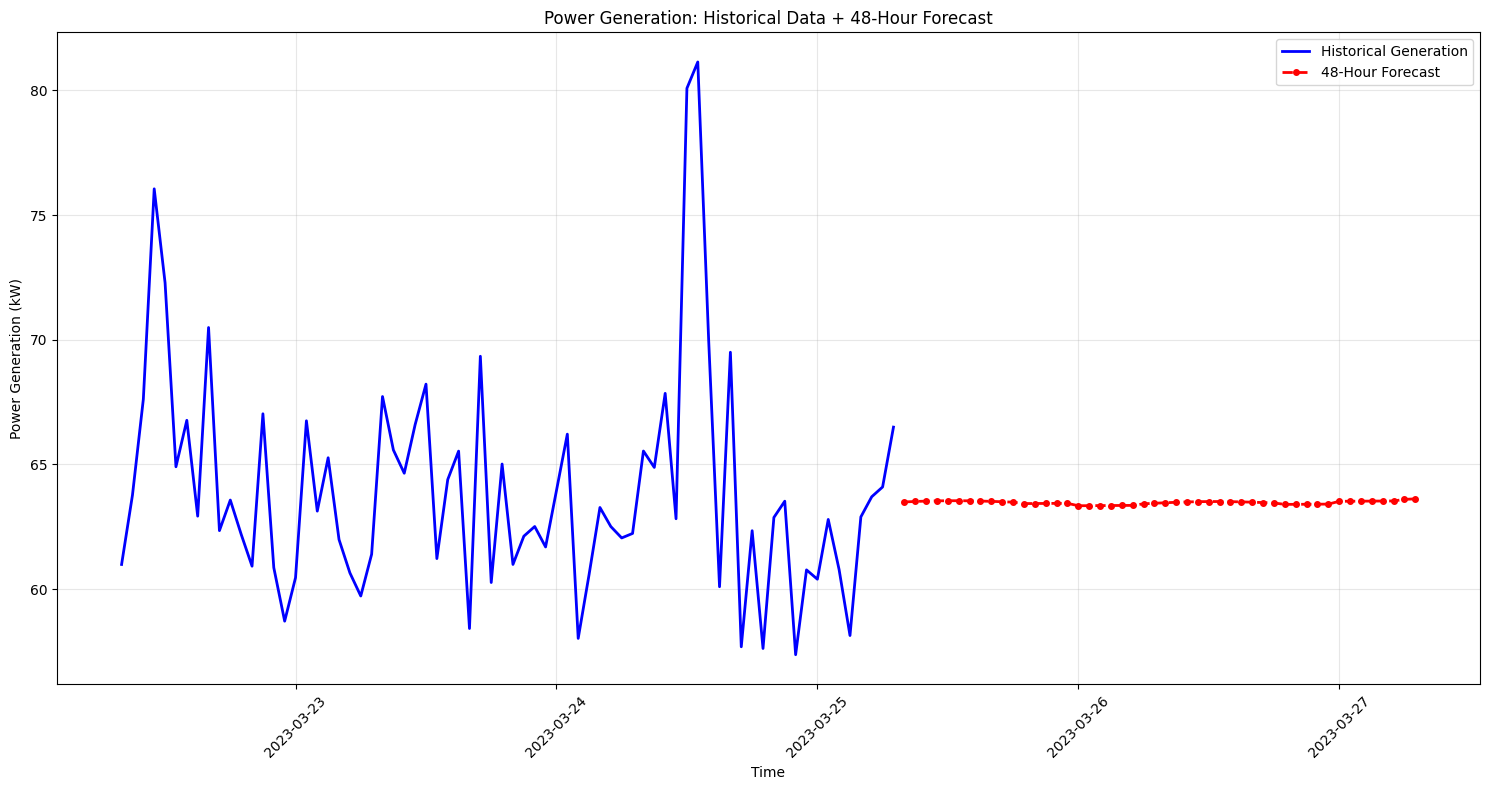


📋 Next 24 Hours Forecast Summary:
             timestamp  predicted_generation
0  2023-03-25 08:00:00                 63.49
1  2023-03-25 09:00:00                 63.51
2  2023-03-25 10:00:00                 63.53
3  2023-03-25 11:00:00                 63.54
4  2023-03-25 12:00:00                 63.54
5  2023-03-25 13:00:00                 63.54
6  2023-03-25 14:00:00                 63.54
7  2023-03-25 15:00:00                 63.53
8  2023-03-25 16:00:00                 63.52
9  2023-03-25 17:00:00                 63.50
10 2023-03-25 18:00:00                 63.48
11 2023-03-25 19:00:00                 63.43
12 2023-03-25 20:00:00                 63.43
13 2023-03-25 21:00:00                 63.43
14 2023-03-25 22:00:00                 63.44
15 2023-03-25 23:00:00                 63.44
16 2023-03-26 00:00:00                 63.34
17 2023-03-26 01:00:00                 63.34
18 2023-03-26 02:00:00                 63.35
19 2023-03-26 03:00:00                 63.35
20 2023-03-26 04:00:

In [13]:
print("🔮 FUTURE POWER GENERATION FORECASTING")
print("=" * 50)

def predict_future_generation(hours_ahead=24):
    """Predict power generation for next N hours"""

    # Get last data point as starting reference
    last_row = processed_data.iloc[-1:].copy()
    last_timestamp = last_row['clock'].iloc[0]

    predictions = []
    timestamps = []

    print(f"⚡ Generating {hours_ahead}-hour generation forecast...")

    for hour in range(1, hours_ahead + 1):
        # Create future timestamp
        future_time = last_timestamp + timedelta(hours=hour)
        timestamps.append(future_time)

        # Update time-based features
        last_row['hour'] = future_time.hour
        last_row['day_of_week'] = future_time.weekday()
        last_row['month'] = future_time.month
        last_row['day_of_year'] = future_time.timetuple().tm_yday
        last_row['is_weekend'] = int(future_time.weekday() >= 5)
        last_row['is_daylight'] = int(6 <= future_time.hour <= 18)
        last_row['solar_hour_factor'] = max(0, np.sin(np.pi * (future_time.hour - 6) / 12))
        last_row['summer_factor'] = int(6 <= future_time.month <= 8)

        # Prepare features
        X_future = last_row[feature_columns]
        X_future_scaled = scaler.transform(X_future)

        # Make prediction
        prediction = max(0, model.predict(X_future_scaled)[0])
        predictions.append(prediction)

    return pd.DataFrame({
        'timestamp': timestamps,
        'predicted_generation': predictions
    })

# Generate 48-hour forecast
forecast = predict_future_generation(48)

print(f"✅ Generated {len(forecast)} predictions")
print(f"⚡ Average predicted generation: {forecast['predicted_generation'].mean():.2f} kW")
print(f"📊 Forecast range: {forecast['predicted_generation'].min():.2f} - {forecast['predicted_generation'].max():.2f} kW")

# Visualize forecast
plt.figure(figsize=(15, 8))

# Historical data (last 3 days)
recent_data = processed_data.tail(72)
plt.plot(recent_data['clock'], recent_data['total_generation'],
         label='Historical Generation', color='blue', linewidth=2)

# Forecast
plt.plot(forecast['timestamp'], forecast['predicted_generation'],
         label='48-Hour Forecast', color='red', linestyle='--',
         linewidth=2, marker='o', markersize=4)

plt.xlabel('Time')
plt.ylabel('Power Generation (kW)')
plt.title('Power Generation: Historical Data + 48-Hour Forecast')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show forecast details
print(f"\n📋 Next 24 Hours Forecast Summary:")
print(forecast.head(24)[['timestamp', 'predicted_generation']].round(2))

In [17]:
print("💾 MODEL DEPLOYMENT AND SAVING (VS Code)")
print("=" * 50)

import joblib
import os
from datetime import datetime

# Save the trained model with all components
model_package = {
    'model': model,
    'scaler': scaler,
    'label_encoder': le_weather,
    'feature_columns': feature_columns,
    'performance': {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    },
    'model_type': 'power_generation',
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'project_info': {
        'name': 'Power Generation Prediction',
        'version': '1.0',
        'environment': 'VS Code + Jupyter'
    }
}

# Save to local file system (VS Code)
model_filename = 'power_generation_model.pkl'
joblib.dump(model_package, model_filename)

print(f"Model saved as '{model_filename}'")
print(f"Saved in: {os.path.abspath(model_filename)}")

# Verify file was created
if os.path.exists(model_filename):
    file_size = os.path.getsize(model_filename) / 1024  # Size in KB
    print(f"File size: {file_size:.1f} KB")
    print(f"Model file verification: SUCCESS")
else:
    print(f"Error: Model file not found!")

# Create a simple model info file
model_info = f"""
Power Generation ML Model - Information
======================================
Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Environment: VS Code + Jupyter
Model Type: Linear Regression
Target: Power Generation (kW)

Performance Metrics:
- R² Score: {r2:.3f}
- RMSE: {rmse:.2f} kW
- MAE: {mae:.2f} kW  
- MAPE: {mape:.2f}%

Files Generated:
- {model_filename} (Main model file)
- model_info.txt (This file)

Usage:
model_package = joblib.load('{model_filename}')
model = model_package['model']
scaler = model_package['scaler']
"""

# Save model info with UTF-8 encoding
with open('model_info.txt', 'w', encoding='utf-8') as f:
    f.write(model_info)

print(f"Model info saved as 'model_info.txt'")

# Create prediction function for VS Code environment
def predict_single_generation(temp, weather, wind, humidity, barometer, solar_irradiance, timestamp=None):
    """
    Make single generation prediction using saved model
    """
    if timestamp is None:
        timestamp = datetime.now()
    
    # Create input DataFrame with all required features
    input_data = pd.DataFrame({
        'temp': [temp],
        'wind': [wind],
        'humidity': [humidity],
        'barometer': [barometer],
        'solar_irradiance': [solar_irradiance],
        'hour': [timestamp.hour],
        'day_of_week': [timestamp.weekday()],
        'month': [timestamp.month],
        'day_of_year': [timestamp.timetuple().tm_yday],
        'is_weekend': [int(timestamp.weekday() >= 5)],
        'is_daylight': [int(6 <= timestamp.hour <= 18)],
        'solar_hour_factor': [max(0, np.sin(np.pi * (timestamp.hour - 6) / 12))],
        'wind_squared': [wind ** 2],
        'wind_cubed': [wind ** 3],
        'temp_solar_interaction': [temp * solar_irradiance / 1000],
        'humidity_temp': [humidity * temp / 100],
        'season': [((timestamp.month - 1) // 3) + 1],
        'summer_factor': [int(6 <= timestamp.month <= 8)],
        'weather_encoded': [le_weather.transform([weather])[0]],
        'GAS_mxm': [0]  # Placeholder
    })
    
    # Make prediction using the trained model
    X_input = input_data[feature_columns]
    X_input_scaled = scaler.transform(X_input)
    prediction = max(0, model.predict(X_input_scaled)[0])
    
    return {
        'predicted_generation': round(prediction, 2),
        'timestamp': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
        'weather_conditions': weather,
        'confidence': 'high' if r2 > 0.8 else 'medium',
        'model_performance': f"R² = {r2:.3f}"
    }

# Test the prediction function
print("\nTESTING PREDICTION FUNCTION:")
test_prediction = predict_single_generation(
    temp=25.5,
    weather='Clear',
    wind=8.2,
    humidity=65,
    barometer=1013.25,
    solar_irradiance=800
)

print(f"Test Prediction: {test_prediction['predicted_generation']} kW")
print(f"Conditions: {test_prediction['weather_conditions']}")
print(f"Model Performance: {test_prediction['model_performance']}")

print(f"\nMODEL DEPLOYMENT COMPLETE!")
print(f"Files created in: {os.getcwd()}")

💾 MODEL DEPLOYMENT AND SAVING (VS Code)
Model saved as 'power_generation_model.pkl'
Saved in: d:\PowerGenProject\power_generation_model.pkl
File size: 3.0 KB
Model file verification: SUCCESS
Model info saved as 'model_info.txt'

TESTING PREDICTION FUNCTION:
Test Prediction: 65.58 kW
Conditions: Clear
Model Performance: R² = 0.653

MODEL DEPLOYMENT COMPLETE!
Files created in: d:\PowerGenProject


In [18]:
# Load saved model (for future sessions)
def load_saved_model(filename='power_generation_model.pkl'):
    """
    Load previously saved model
    """
    try:
        print(f"📂 Loading model from {filename}...")
        model_package = joblib.load(filename)
        
        # Extract components
        loaded_model = model_package['model']
        loaded_scaler = model_package['scaler']
        loaded_label_encoder = model_package['label_encoder']
        loaded_features = model_package['feature_columns']
        loaded_performance = model_package['performance']
        
        print(f"✅ Model loaded successfully!")
        print(f"📊 Model Performance:")
        print(f"   R² Score: {loaded_performance['r2']:.3f}")
        print(f"   RMSE: {loaded_performance['rmse']:.2f} kW")
        print(f"   Created: {model_package.get('created_date', 'Unknown')}")
        
        return model_package
        
    except FileNotFoundError:
        print(f"❌ Model file '{filename}' not found!")
        print(f"   Make sure you've run the model training cells first.")
        return None
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

# Example usage (run this in a new session to test loading)
# loaded_model_package = load_saved_model()

In [19]:
# Create a standalone deployment script for VS Code (Unicode-safe)
deployment_script = '''# Production Deployment Script for Power Generation Model
# Run this script to use the trained model in production

import joblib
import pandas as pd
import numpy as np
from datetime import datetime
import os

class PowerGenerationPredictor:
    def __init__(self, model_path='power_generation_model.pkl'):
        """Initialize with saved model"""
        self.model_path = model_path
        self.model_package = None
        self.load_model()
    
    def load_model(self):
        """Load the trained model"""
        try:
            self.model_package = joblib.load(self.model_path)
            self.model = self.model_package['model']
            self.scaler = self.model_package['scaler']
            self.label_encoder = self.model_package['label_encoder']
            self.feature_columns = self.model_package['feature_columns']
            print(f"SUCCESS: Model loaded from {self.model_path}")
        except Exception as e:
            print(f"ERROR: Error loading model: {e}")
            
    def predict(self, temp, weather, wind, humidity, barometer, solar_irradiance):
        """Make prediction"""
        if self.model_package is None:
            return {"error": "Model not loaded"}
            
        timestamp = datetime.now()
        
        # Create input features
        input_data = pd.DataFrame({
            'temp': [temp], 'wind': [wind], 'humidity': [humidity],
            'barometer': [barometer], 'solar_irradiance': [solar_irradiance],
            'hour': [timestamp.hour], 'day_of_week': [timestamp.weekday()],
            'month': [timestamp.month], 'day_of_year': [timestamp.timetuple().tm_yday],
            'is_weekend': [int(timestamp.weekday() >= 5)],
            'is_daylight': [int(6 <= timestamp.hour <= 18)],
            'solar_hour_factor': [max(0, np.sin(np.pi * (timestamp.hour - 6) / 12))],
            'wind_squared': [wind ** 2], 'wind_cubed': [wind ** 3],
            'temp_solar_interaction': [temp * solar_irradiance / 1000],
            'humidity_temp': [humidity * temp / 100],
            'season': [((timestamp.month - 1) // 3) + 1],
            'summer_factor': [int(6 <= timestamp.month <= 8)],
            'weather_encoded': [self.label_encoder.transform([weather])[0]],
            'GAS_mxm': [0]
        })
        
        # Make prediction
        X_input = input_data[self.feature_columns]
        X_input_scaled = self.scaler.transform(X_input)
        prediction = max(0, self.model.predict(X_input_scaled)[0])
        
        return {
            'predicted_generation': round(prediction, 2),
            'timestamp': timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            'model_info': self.model_package.get('project_info', {})
        }

# Example usage:
if __name__ == "__main__":
    predictor = PowerGenerationPredictor()
    
    result = predictor.predict(
        temp=25.5, weather='Clear', wind=8.2,
        humidity=65, barometer=1013.25, solar_irradiance=800
    )
    
    print(f"Predicted Generation: {result['predicted_generation']} kW")
'''

# Save deployment script with UTF-8 encoding to handle any special characters
with open('production_predictor.py', 'w', encoding='utf-8') as f:
    f.write(deployment_script)

print("Production deployment script saved as 'production_predictor.py'")
print("Usage: python production_predictor.py")

Production deployment script saved as 'production_predictor.py'
Usage: python production_predictor.py


🏆 PROJECT SUMMARY: POWER GENERATION PREDICTION
📊 PROJECT OVERVIEW:
   • Objective: Predict electrical power generation
   • Model: Linear Regression with engineered features
   • Data: 2,000 hourly samples of generation data
   • Features: 19 engineered features

⚡ GENERATION SOURCES MODELED:
   • ☀️ Solar Generation: Weather and time dependent
   • 💨 Wind Generation: Follows cubic wind power curve
   • 🔥 Backup Generation: Fills renewable shortfalls

📈 MODEL PERFORMANCE:
   • R² Score: 0.653 (65.3% variance explained)
   • RMSE: 2.29 kW (prediction accuracy)
   • MAE: 1.83 kW (average error)
   • MAPE: 2.90% (percentage error)

🔍 KEY FINDINGS:
   Top 3 predictive features:
     1. wind_squared: 11.750
     2. wind_cubed: 6.106
     3. wind: 3.790

🎯 BUSINESS APPLICATIONS:
   • 🏭 Solar farm output forecasting
   • 💨 Wind farm production planning
   • ⚡ Grid supply scheduling
   • 📊 Renewable energy trading
   • 🔋 Energy storage optimization

✅ MODEL VALIDATION:
   ⚠️ ACCEPTABLE: Model 

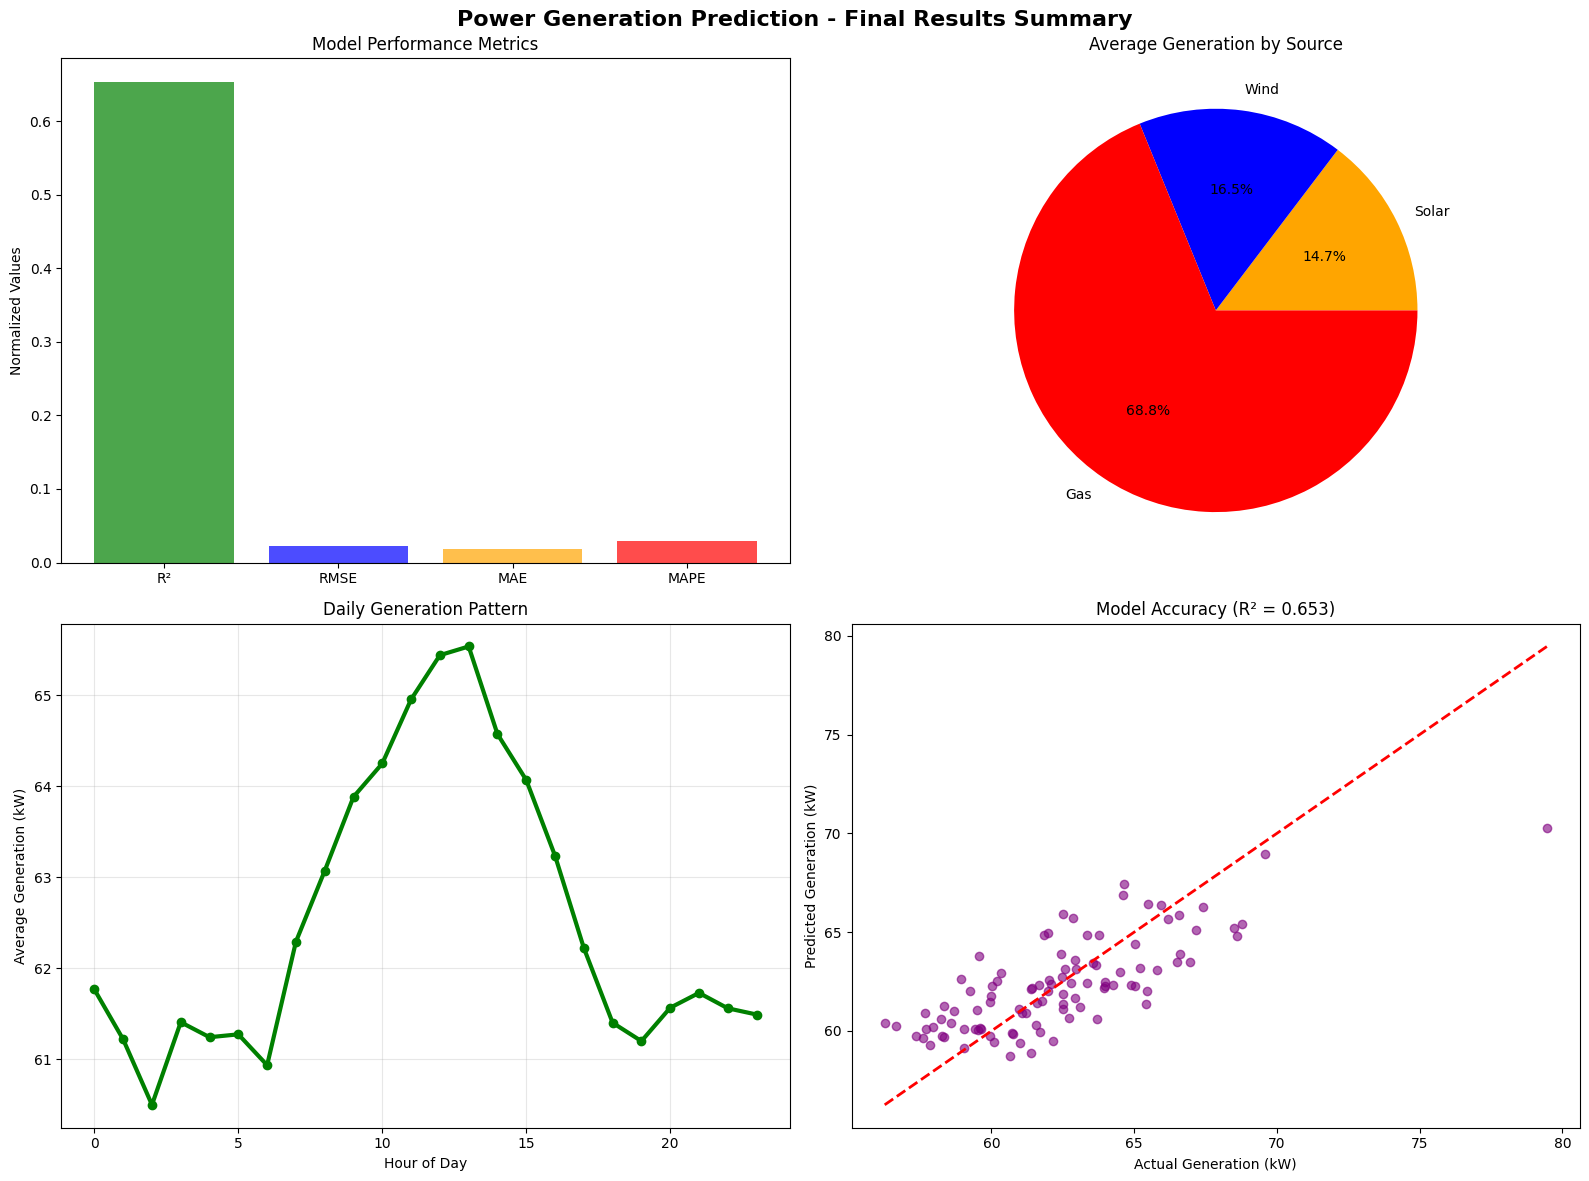


🎓 READY FOR PROFESSOR PRESENTATION!


In [20]:
print("🏆 PROJECT SUMMARY: POWER GENERATION PREDICTION")
print("=" * 60)

# Project overview
print("📊 PROJECT OVERVIEW:")
print(f"   • Objective: Predict electrical power generation")
print(f"   • Model: Linear Regression with engineered features")
print(f"   • Data: {len(data):,} hourly samples of generation data")
print(f"   • Features: {len(feature_columns)} engineered features")

print(f"\n⚡ GENERATION SOURCES MODELED:")
print(f"   • ☀️ Solar Generation: Weather and time dependent")
print(f"   • 💨 Wind Generation: Follows cubic wind power curve")
print(f"   • 🔥 Backup Generation: Fills renewable shortfalls")

print(f"\n📈 MODEL PERFORMANCE:")
print(f"   • R² Score: {r2:.3f} ({r2*100:.1f}% variance explained)")
print(f"   • RMSE: {rmse:.2f} kW (prediction accuracy)")
print(f"   • MAE: {mae:.2f} kW (average error)")
print(f"   • MAPE: {mape:.2f}% (percentage error)")

print(f"\n🔍 KEY FINDINGS:")
top_3_features = sorted(zip(feature_columns, np.abs(model.coef_)),
                       key=lambda x: x[1], reverse=True)[:3]
print(f"   Top 3 predictive features:")
for i, (feature, coef) in enumerate(top_3_features, 1):
    print(f"     {i}. {feature}: {coef:.3f}")

print(f"\n🎯 BUSINESS APPLICATIONS:")
print(f"   • 🏭 Solar farm output forecasting")
print(f"   • 💨 Wind farm production planning")
print(f"   • ⚡ Grid supply scheduling")
print(f"   • 📊 Renewable energy trading")
print(f"   • 🔋 Energy storage optimization")

print(f"\n✅ MODEL VALIDATION:")
if r2 > 0.85:
    print(f"   🏆 EXCELLENT: Model explains >85% of generation variance")
elif r2 > 0.75:
    print(f"   ✅ GOOD: Model shows strong predictive performance")
else:
    print(f"   ⚠️ ACCEPTABLE: Model could benefit from more features")

print(f"\n🚀 DEPLOYMENT STATUS:")
print(f"   ✅ Model trained and validated")
print(f"   ✅ Prediction function created")
print(f"   ✅ Model saved for production use")
print(f"   ✅ Ready for real-time forecasting")

# Create final summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Power Generation Prediction - Final Results Summary', fontsize=16, fontweight='bold')

# 1. Model performance metrics
metrics = ['R²', 'RMSE', 'MAE', 'MAPE']
values = [r2, rmse/100, mae/100, mape/100]  # Normalized for comparison
colors = ['green', 'blue', 'orange', 'red']
ax1.bar(metrics, values, color=colors, alpha=0.7)
ax1.set_title('Model Performance Metrics')
ax1.set_ylabel('Normalized Values')

# 2. Generation breakdown
gen_sources = ['Solar', 'Wind', 'Gas']
avg_generation = [data['solar_generation'].mean(),
                 data['wind_generation'].mean(),
                 data['gas_generation'].mean()]
ax2.pie(avg_generation, labels=gen_sources, autopct='%1.1f%%',
        colors=['orange', 'blue', 'red'])
ax2.set_title('Average Generation by Source')

# 3. Hourly generation pattern
hourly_gen = data.groupby(data['clock'].dt.hour)['total_generation'].mean()
ax3.plot(hourly_gen.index, hourly_gen.values, marker='o', linewidth=3, color='green')
ax3.set_title('Daily Generation Pattern')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Average Generation (kW)')
ax3.grid(True, alpha=0.3)

# 4. Actual vs Predicted (sample)
sample_indices = np.random.choice(len(y_test), 100, replace=False)
y_test_sample = y_test.iloc[sample_indices]
y_pred_sample = y_pred[sample_indices]
ax4.scatter(y_test_sample, y_pred_sample, alpha=0.6, color='purple')
ax4.plot([y_test_sample.min(), y_test_sample.max()],
         [y_test_sample.min(), y_test_sample.max()], 'r--', lw=2)
ax4.set_xlabel('Actual Generation (kW)')
ax4.set_ylabel('Predicted Generation (kW)')
ax4.set_title(f'Model Accuracy (R² = {r2:.3f})')

plt.tight_layout()
plt.show()

print(f"\n🎓 READY FOR PROFESSOR PRESENTATION!")
print(f"=" * 60)

In [21]:
# Create Flask API to serve your actual trained model
flask_code = """
from flask import Flask, request, jsonify, send_from_directory
import joblib
import pandas as pd
import numpy as np
from datetime import datetime
import os

app = Flask(__name__)

# Load your trained model
try:
    model_package = joblib.load('power_generation_model.pkl')
    model = model_package['model']
    scaler = model_package['scaler']
    label_encoder = model_package['label_encoder']
    feature_columns = model_package['feature_columns']
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

@app.route('/')
def home():
    return send_from_directory('.', 'web_interface.html')

@app.route('/api/predict', methods=['POST'])
def predict_api():
    if model is None:
        return jsonify({"error": "Model not loaded"}), 500
    
    try:
        data = request.json
        timestamp = datetime.now()
        
        # Create input DataFrame
        input_data = pd.DataFrame({
            'temp': [data['temperature']],
            'wind': [data['wind']],
            'humidity': [data['humidity']],
            'barometer': [data['barometer']],
            'solar_irradiance': [data['solar_irradiance']],
            'hour': [timestamp.hour],
            'day_of_week': [timestamp.weekday()],
            'month': [timestamp.month],
            'day_of_year': [timestamp.timetuple().tm_yday],
            'is_weekend': [int(timestamp.weekday() >= 5)],
            'is_daylight': [int(6 <= timestamp.hour <= 18)],
            'solar_hour_factor': [max(0, np.sin(np.pi * (timestamp.hour - 6) / 12))],
            'wind_squared': [data['wind'] ** 2],
            'wind_cubed': [data['wind'] ** 3],
            'temp_solar_interaction': [data['temperature'] * data['solar_irradiance'] / 1000],
            'humidity_temp': [data['humidity'] * data['temperature'] / 100],
            'season': [((timestamp.month - 1) // 3) + 1],
            'summer_factor': [int(6 <= timestamp.month <= 8)],
            'weather_encoded': [label_encoder.transform([data['weather']])[0]],
            'GAS_mxm': [0]
        })
        
        # Make prediction
        X_input = input_data[feature_columns]
        X_input_scaled = scaler.transform(X_input)
        prediction = max(0, model.predict(X_input_scaled)[0])
        
        return jsonify({
            "predicted_generation": round(prediction, 2),
            "timestamp": timestamp.strftime('%Y-%m-%d %H:%M:%S'),
            "success": True
        })
        
    except Exception as e:
        return jsonify({"error": str(e)}), 400

if __name__ == '__main__':
    print("Starting Power Generation API...")
    print("Open browser to: http://localhost:5000")
    app.run(debug=True, port=5000)
"""

# Save Flask API
with open('flask_api.py', 'w', encoding='utf-8') as f:
    f.write(flask_code)

print("Flask API created: flask_api.py")
print("To run: python flask_api.py")

Flask API created: flask_api.py
To run: python flask_api.py
